<a href="https://colab.research.google.com/github/DanielKorenDataScience/ClassificationProject/blob/main/Classification_Project_Shufersal.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Classification Project

for Shufersal on-line orders, for replacing of missing products, will predict the replacement success!

In [1]:
import requests
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

from IPython.display import display
p = print
d = display

# Get Data

## Raw Data

To run the raw section, one must load Sweets_ver2.csv to local google drive and change the next line to True

In [2]:
RAW = False

In [3]:
def get_raw(fname):
  data_url = 'https://github.com/DanielKorenDataScience/ClassificationProject/blob/main/' + fname + '.csv?raw=true'
  resp = requests.get(data_url)
  text = resp.text
  
  with open(fname + '.csv', 'w') as fh:
    fh.write(text)

In [4]:
def diff_list(li1, li2):
  return [i for i in li1 + li2 if i not in li1 or i not in li2]

In [5]:
if RAW:    
  df1 = pd.read_csv('/content/drive/MyDrive/Sweets_ver2.csv', encoding='ISO-8859-8', nrows=1)
  df2 = pd.read_csv('/content/drive/MyDrive/Sweets_ver2.csv', encoding='ISO-8859-8', usecols=[i for i in range(82) if not i in[0,8,10,12,14,16,18,20,24,26,27,48,50,52,54,56,58,60,62,64,65]])

Eliminating unwanted columns - **1. ITAY, please verify I did not delete a feature by mistake**

In [6]:
if RAW:
  d(diff_list(list(df1.columns), list(df2.columns)))

In [7]:
if RAW:
  d(df2.info())

In [8]:
# Fix Typo mistake
if RAW: 
  df2.rename(columns={'OrderNumbert': 'OrderNumber','BrandIndDescSuss': 'BrandIndDescSubs', 'ProductNumberSubs': 'ParentProductNumberSubs', 
                    'NetSaleNoVatPrdSubs': 'NetSaleNoVatPrdLast3MonthsSubs', 'CafiotSucarSusb': 'CafiotSucarSubs'}, inplace=True)

Eliminating nulls - **2. ITAY, please verify I took care of all the features**

In [9]:
# Fill na
if RAW:
  df2.fillna({'QuantSale': 1, 'QuantSaleSubs': 1}, inplace=True)
  df2.fillna(0, inplace=True)
  d(df2.info())

In [10]:
if RAW:
  df2.to_csv("Shufersal.csv", index = False)
  p(df2.shape)

In [11]:
if RAW:
  df = pd.read_csv('Shufersal.csv', index_col=False)
  p(df.shape)

## Encoding categories

**3. ITAY, please check I categorized all the features**

In [12]:
from sklearn.preprocessing import LabelEncoder
enc = LabelEncoder()
if RAW:
  for col in ['LocationCityName', 'PeriodHoliday', 'BrandIndDesc', 'BrandName', 'isPromo', 'BrandIndDescSubs']:
    p(col)
    p(pd.DataFrame(df[col].value_counts()).index)
    df[col] = enc.fit_transform(df[col])
    p(pd.DataFrame(df[col].value_counts()).index)

## Calc diff vector

**4. ITAY, there are no ['PeriodHoliday', 'BrandName', 'isPromo', 'Quantity', 'cntPrdAll', 'NetSaleAmountAll'] in subs**

In [13]:
if RAW:
  for col in ['DepartmentCode', 'CategoryCode', 'GroupCode', 'SubGroupCode',
       'CompoundID', 'ParentProductNumber', 'BrandIndDesc',
       'VendorNumber', 'UnitOfMeasure', 'Price', 'NetSaleNoVatPrdLast3Months', 'Energy', 'Pachmema',
       'Natran', 'Helbon', 'Shuman', 'ShumanRavuy', 'ShumanTrans', 'Colastrol',
       'SivimTzunatim', 'CafiotSucar']:
    df[col + 'Diff'] = df[col] - df[col + 'Subs']

In [14]:
if RAW:
  for col in ['DepartmentCode', 'CategoryCode', 'GroupCode', 'SubGroupCode',
       'CompoundID', 'ParentProductNumber', 'UnitOfMeasure', 'VendorNumber']:
    df[col + 'Diff'] = (df[col + 'Diff'] != 0)
    df[col + 'Diff'] = enc.fit_transform(df[col + 'Diff'])

In [15]:
if RAW:
  p(df.shape)

In [16]:
if RAW:
  df.to_csv("Shufersal_with_diff.csv", index = False)

In [17]:
if RAW:
  df = pd.read_csv('Shufersal_with_diff.csv', index_col=False)
  p(df.shape)

In [18]:
if RAW:
  d(df.head())

# Get ready Data

In [19]:
get_raw('Shufersal_with_diff')

In [20]:
df = pd.read_csv('Shufersal_with_diff.csv', encoding='ISO-8859-8')
p(df.shape)
df.head()

(54460, 82)


,HouseHoldID,LocationCityName,QuarterNumber,MonthNumber,WeekNumber,DayNumberInWeek,PeriodHoliday,DepartmentCode,CategoryCode,GroupCode,SubGroupCode,CompoundID,ParentProductNumber,BrandIndDesc,BrandName,VendorNumber,UnitOfMeasure,Price,Quantity,cntPrdAll,NetSaleAmountAll,NetSaleNoVatPrdLast3Months,QuantSale,cntMonths,DiscountPerUnit,isPromo,Energy,Pachmema,Natran,Helbon,Shuman,ShumanRavuy,ShumanTrans,Colastrol,SivimTzunatim,CafiotSucar,DepartmentCodeSubs,CategoryCodeSubs,GroupCodeSubs,SubGroupCodeSubs,...,BrandIndDescSubs,VendorNumberSubs,UnitOfMeasureSubs,PriceSubs,NetSaleNoVatPrdLast3MonthsSubs,QuantSaleSubs,cntMonthsSubs,DiscountPerUnitSubs,EnergySubs,PachmemaSubs,NatranSubs,HelbonSubs,ShumanSubs,ShumanRavuySubs,ShumanTransSubs,ColastrolSubs,SivimTzunatimSubs,CafiotSucarSubs,CorrelateItemStatusCode,DepartmentCodeDiff,CategoryCodeDiff,GroupCodeDiff,SubGroupCodeDiff,CompoundIDDiff,ParentProductNumberDiff,BrandIndDescDiff,VendorNumberDiff,UnitOfMeasureDiff,PriceDiff,NetSaleNoVatPrdLast3MonthsDiff,EnergyDiff,PachmemaDiff,NatranDiff,HelbonDiff,ShumanDiff,ShumanRavuyDiff,ShumanTransDiff,ColastrolDiff,SivimTzunatimDiff,CafiotSucarDiff
0,1,87,202101,202102,202108,1,1,10,6,700,3,-8000500249352,8000500249352,52,0,914547,0.205,18.90,4,22,800.63,57747.16,0.8,16,0.000,2,568.0,49.5,107.0,8.6,37.8,17.3,0.5,15.0,0.0,0.00,10,6,700,6,...,67,914547,0.086,9.90,46128.25,0.8,13,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,1,0,0,0,1,1,0,-15,0,1,9.0,11618.91,568.0,49.5,107.0,8.6,37.8,17.3,0.5,15.0,0.0,0.00
1,2,87,202101,202103,202112,1,0,10,6,699,4,2900,178134,44,0,912069,0.400,19.60,1,12,207.30,141798.59,0.6,16,0.000,2,514.0,51.0,0.0,5.3,31.0,19.2,0.5,0.0,0.0,12.25,10,6,699,4,...,58,912069,0.300,10.00,67947.93,0.8,15,0.0,514.0,51.0,0.0,5.3,31.0,19.2,0.5,0.0,0.0,12.25,1,0,0,0,0,1,0,-14,0,1,9.6,73850.66,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00
2,3,87,202101,202101,202101,5,1,10,6,699,3,12043,7610400091060,25,0,912317,0.100,14.90,1,69,1813.38,80904.21,0.7,11,2.823,0,534.0,51.0,34.0,6.9,32.0,17.0,0.5,10.0,0.0,11.50,10,6,699,3,...,16,910165,0.090,9.90,20718.49,1.0,13,0.0,532.0,51.0,21.0,6.5,30.0,18.0,0.5,7.5,7.8,12.00,0,0,0,0,0,1,0,9,1,1,5.0,60185.72,2.0,0.0,13.0,0.4,2.0,-1.0,0.0,2.5,-7.8,-0.50
3,4,87,202101,202101,202104,5,0,10,6,699,2,8579,7290112490124,53,0,912268,0.085,2.95,1,54,924.45,18277.75,1.0,14,0.899,0,527.0,67.4,117.0,7.4,25.3,16.3,0.5,11.0,0.0,12.75,10,6,699,2,...,69,912268,0.085,2.95,32291.02,0.9,16,0.0,506.0,64.2,132.0,8.1,24.1,14.9,0.5,8.0,0.0,12.50,1,0,0,0,0,0,0,-16,0,0,0.0,-14013.27,21.0,3.2,-15.0,-0.7,1.2,1.4,0.0,3.0,0.0,0.25
4,5,87,202101,202102,202105,5,1,10,6,699,3,30727,7296073382416,55,1,913725,0.100,8.00,4,69,1468.61,45785.99,0.8,16,1.857,0,607.0,13.0,10.0,11.0,53.0,32.0,0.5,0.0,17.0,2.00,10,6,699,3,...,71,913725,0.100,8.00,41347.56,0.9,16,0.0,603.0,23.0,10.0,8.7,50.0,30.0,0.5,0.0,13.0,4.50,1,0,0,0,0,0,0,-16,0,0,0.0,4438.43,4.0,-10.0,0.0,2.3,3.0,2.0,0.0,0.0,4.0,-2.50


# Models

In [51]:
from sklearn.model_selection import train_test_split

X = df.drop('CorrelateItemStatusCode', axis=1)
y = df.CorrelateItemStatusCode.astype(int)

X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.7, random_state=0)

In [52]:
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
import math

pd.set_option("precision", 2)
df_result = pd.DataFrame()

In [23]:
def report_old(clf, X, y, data_type='Test'):
  p()
  p(type(clf).__name__ + ': ' + data_type)
  p('_____________________________________________________')
  acc = accuracy_score(y_true=y, y_pred=clf.predict(X))
  cm = pd.DataFrame(confusion_matrix(y_true=y, y_pred=clf.predict(X)),
                    index=clf.classes_,
                    columns=clf.classes_)
  d(cm)
  rep = classification_report(y_true=y, y_pred=clf.predict(X), zero_division=1, output_dict=True)
  rep =  pd.DataFrame(rep)
  rep.drop(['accuracy', 'macro avg', 'weighted avg'], axis=1, inplace=True)
  rep = rep.T
  rep['accuracy'] = acc
  rep.support = rep.support.astype(int)
  cols = list(rep.columns[:3]) + ['accuracy', 'support']
  rep = rep[cols]
  d(rep)
  return

In [53]:
def report(clf, X, y, data_type='Test'):
  global df_result
  name = type(clf).__name__ + ': ' + data_type
  acc = accuracy_score(y_true=y, y_pred=clf.predict(X))
  index = [(name, clf.classes_[0]), (name, clf.classes_[1])]
  cm = pd.DataFrame(confusion_matrix(y_true=y, y_pred=clf.predict(X)),
                    index=clf.classes_,
                    columns=clf.classes_)
  cm.reset_index(drop=True, inplace=True)
  rep = classification_report(y_true=y, y_pred=clf.predict(X), zero_division=1, output_dict=True)
  rep =  pd.DataFrame(rep)
  rep.drop(['accuracy', 'macro avg', 'weighted avg'], axis=1, inplace=True)
  rep = rep.T
  rep['accuracy'] = acc
  rep.support = rep.support.astype(int)
  cols = list(rep.columns[:3]) + ['accuracy', 'support']
  rep = rep[cols]
  rep['precision_avg'] = rep.precision.mean()
  rep['recall_avg'] = rep.recall.mean()
  rep['f1-score_avg'] = rep['f1-score'].mean()
  rep.reset_index(drop=True, inplace=True)
  df = cm.join(rep)
  df['name'] = name
  df.reset_index(inplace=True)
  #df.set_index(['name', 'index'], inplace=True)
  df_result.reset_index(inplace=True)
  df_result = df_result.append(df, ignore_index=True)
  df_result.set_index(['name', 'index'], inplace=True)
  #d(df_result)
  return

In [58]:
def showFeatureImportance(model, X_train=X_train, threshold=0):
  if type(model).__name__ == 'LogisticRegression':  # no features importance data
    w0 = model.intercept_[0]
    w = model.coef_[0]
    fx_imp = pd.Series(w, index=X_train.columns)
  else:
    fx_imp = pd.Series(model.feature_importances_, index=X_train.columns)
  fx_imp /= fx_imp.sum()
  fx_imp = fx_imp.sort_values()
  fx_imp = fx_imp[fx_imp > threshold]
  fig = plt.figure(figsize=(5,5))
  plt.xlim(0, 1)
  fx_imp.plot(kind='barh', title=type(model).__name__ )

In [55]:
def process_model(model, X_train=X_train, y_train=y_train, X_test=X_test, y_test=y_test, plot=False, threshold=0):
  p('running: ', type(model).__name__)
  model.fit(X_train, y_train)
  report(model, X_train, y_train, 'Train')
  report(model, X_test, y_test)
  if plot:
    showFeatureImportance(model, X_train, threshold) 

In [56]:
from sklearn.linear_model import LogisticRegression, BayesianRidge, Lasso, Ridge
from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier, AdaBoostClassifier, GradientBoostingRegressor, BaggingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import LinearSVC

running:  LogisticRegression
running:  LogisticRegression
running:  GradientBoostingClassifier
running:  AdaBoostClassifier
running:  AdaBoostClassifier
running:  RandomForestClassifier
running:  KNeighborsClassifier


0  ...  f1-score_avg
name                              index           ...              
LogisticRegression: Train         0          0.0  ...          0.40
                                  1          0.0  ...          0.40
LogisticRegression: Test          0          0.0  ...          0.40
                                  1          0.0  ...          0.40
LogisticRegression: Train         0          0.0  ...          0.40
                                  1          0.0  ...          0.40
LogisticRegression: Test          0          0.0  ...          0.40
                                  1          0.0  ...          0.40
GradientBoostingClassifier: Train 0       7967.0  ...          0.79
                                  1       2087.0  ...          0.79
GradientBoostingClassifier: Test  0       3396.0  ...          0.78
                                  1        951.0  ...          0.78
AdaBoostClassifier: Train         0       7725.0  ...          0.76
                                  1       2680.0  ...          0.76
AdaBoostClassifier: Test          0       3304.0  ...          0.76
                                  1       1206.0  ...          0.76
AdaBoostClassifier: Train         0       7324.0  ...          0.76
                                  1       2036.0  ...          0.76
AdaBoostClassifier: Test          0       3162.0  ...          0.76
                                  1        942.0  ...          0.76
RandomForestClassifier: Train     0      12645.0  ...          1.00
                                  1          3.0  ...          1.00
RandomForestClassifier: Test      0       4081.0  ...          0.84
                                  1       1003.0  ...          0.84
KNeighborsClassifier: Train       0       3754.0  ...          0.60
                                  1       2490.0  ...          0.60
KNeighborsClassifier: Test        0       1519.0  ...          0.58
                                  1       1197.0  ...          0.58

[28 rows x 10 columns]

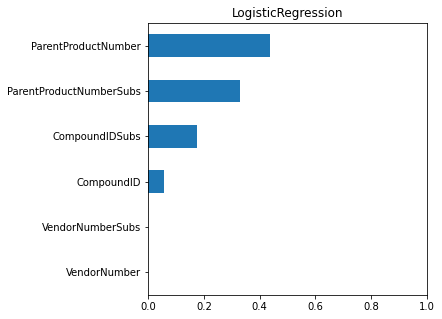

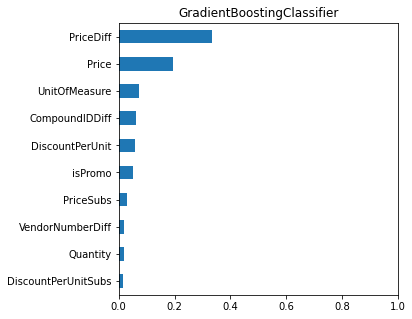

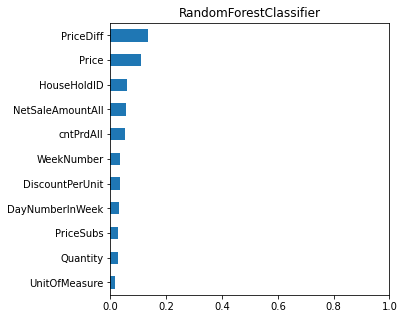

In [59]:
df_result = pd.DataFrame()

process_model(LogisticRegression(max_iter=1000), threshold=0.0000005)  # did not fit, return accuracy=0, so we increased max_iter from default 100
process_model(LogisticRegression(C=100, max_iter=1000, fit_intercept=False, warm_start=True), threshold=0.0000005, plot=True)
process_model(GradientBoostingClassifier(n_estimators=100), plot=True, threshold=0.015)
process_model(AdaBoostClassifier(n_estimators=100))  # base estimator is DecisionTreeClassifier initialized with max_depth=1
process_model(AdaBoostClassifier(base_estimator=DecisionTreeClassifier(max_depth=5), n_estimators=100, learning_rate=0.01))
process_model(RandomForestClassifier(n_estimators=64), plot=True, threshold=0.015)
process_model(KNeighborsClassifier(n_neighbors=39))

if False: # ERROR: Classification metrics can't handle a mix of binary and continuous targets
  process_model(GradientBoostingRegressor(n_estimators=100, max_depth=5))
  process_model(BayesianRidge())
  process_model(Lasso())
  process_model(Ridge(alpha = 0.5))
if False: ## too long > 4 minutes
  process_model(LinearSVC(penalty='l2', loss='squared_hinge', dual=True, tol=0.0001, C=0.1, max_iter=20000)) # max_iter increaed from default 1000 to 3000, 6000, 20000 because did not coverged warning
  from sklearn import svm
  process_model(svm.SVC())
  process_model(svm.SVR())

d(df_result)

# TODO:

In [ ]:
if False:
  from sklearn.cross_validation import cross_val_score
  from sklearn.ensemble import VotingClassifier

  process_model(VotingClassifier(estimators=[('GBR', model1), ('BR', model2), ('KNN', model3)], voting='soft'))

run a model with the important feature alone to show is it a must or just necessary (if the drop in precision is large it is not a must)?

> ### Bagging (Bootstrap Aggregation)

> One classifier ("base model") and try to fit many different subsamples of the data

> The hyper-parameters "max_samples" and "max_features" control the size of the subsets

> The hyper-parameters "bootstrap" and "bootstrap_features" control wether the samples and the features are drawn with (or without) replacement

In [ ]:
clf_base = DecisionTreeClassifier(max_depth=5)

In [ ]:
clf_bagging = BaggingClassifier(base_estimator=clf_base, n_estimators=50)
clf_bagging.fit(X_train, y_train)

clf_bagging.score(X_train, y_train)
clf_bagging.score(X_test, y_test)

In [ ]:
## Converting the categories column (hour and day.of.week) to dummies column improve dramatically the accuracy of the train (up to 0.808 from 0.585)
dessert1 = pd.get_dummies(dessert, columns=['day.of.week', 'hour'])